# The lapidarist problem (Data preprocessing)
After I applied the data cleaning I needed to analize the problem to proposse some models as each model needs different data ssumptions and requirements. The problem is a regression problem as I need to predict the price of a diamond based on their characteristics and by looking at the features it feels like there should not be much complexity in the relationship of the variables nor very complex patterns in the data. 

The benchmark model I chosed is a MLR as is an easy and interpretable model and relatively easy to scale and implement. Linear regression models requires the data to meet some assumptions such as: 
- Linearity: MLR assumes a linear relationship between the independent variables and the target variable
- Independence: Observations should be independent from each other
- Homosedasticity: The residual should have constant variance accross all independent variables
- Mulitcollinearity: One independent variable should not explain another independent variable.
- Scaling: Features should ideally be scaled to the same range.

In [28]:
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

data = pd.read_csv('Data/cleaned_data.csv')

# Function lib
def dqr(data):
    """
    Generate a Data Quality Report
    """
    cols = pd.DataFrame(list(data.columns.values),
                           columns=['Names'],
                           index=list(data.columns.values))
    dtyp = pd.DataFrame(data.dtypes,columns=['Type'])
    misval = pd.DataFrame(data.isnull().sum(),
                                  columns=['Missing_values'])
    presval = pd.DataFrame(data.count(),
                                  columns=['Present_values'])
    unival = pd.DataFrame(columns=['Unique_values'])
    minval = pd.DataFrame(columns=['Min_value'])
    maxval = pd.DataFrame(columns=['Max_value'])
    for col in list(data.columns.values):
        unival.loc[col] = [data[col].nunique()]
        try:
            minval.loc[col] = [data[col].min()]
            maxval.loc[col] = [data[col].max()]
        except:
            pass
    
    return cols.join(dtyp).join(misval).join(presval).join(unival).join(minval).join(maxval)
    
def remove_outliers_sd(df, column, n_std=3):
    """
    Filtering & cleaning outliers
    """
    mean, std = df[column].mean(), df[column].std()
    cutoff = std * n_std
    lower, upper = mean - cutoff, mean + cutoff
    return df[(df[column] >= lower) & (df[column] <= upper)]

def mean_imputing(df, column):
    """
    Replacing missing values in a vector with the mean of the vector.
    Use it when the vector follows a normal distribution.
    """
    mean = df[column].mean()
    df[column] = df[column].fillna(mean)

def meadian_imputing(df, column):
    """
    Replacing missing values in a vector with the median of the vector.
    Use it when the vector has skewness.
    """
    median = df[column].median()
    df[column] = df[column].fillna(median)

def plot_distributions(df, list_of_variables):
    """
    Plot histograms for numerical variables.
    
    Parameters:
    data (pd.DataFrame): Input DataFrame.
    numerical_vars (list): List of numerical variable names.
    """
    num_vars = len(list_of_variables)
    num_rows = (num_vars + 1) // 2
    fig, axs = plt.subplots(nrows=num_rows, ncols=2, figsize=(10, num_rows * 3))

    for i, var in enumerate(list_of_variables):
        row = i // 2
        col = i % 2
        ax = axs[row, col]
        df[var].hist(bins=20, ax=ax)
        ax.set_title(var)

    if num_vars % 2 != 0:
        fig.delaxes(axs[num_rows - 1, 1])

    plt.tight_layout()
    plt.subplots_adjust(top=0.9, hspace=0.5)
    plt.suptitle('Histograms for Continuous Variables', fontsize=16)
    plt.show()

def plot_linearity(df, x_features, target_variable):
    """ 
    Plot linear relationships between independent variables and the target variable
    
    Parameters:
    df (pd.DataFrame): Input DataFrame.
    x_features (List): List of independent continous variables
    target_variable (str): Name of target variable
    """
    sns.pairplot(data=df, x_vars=x_features, y_vars=target_variable)

def ordinal_encoding(df, variable, mapping):
    """ 
    Generate ordinal encoding for categorical values

    Parameters:
    df (pd.DataFrame): Input DataFrame
    variable (str): name of categorical variable
    map (dict): encoding map
    """
    df[variable] = df[variable].map(mapping)

def plot_correlation_matrix(data, numerical_vars):
    """
    Plot correlation matrix for numerical variables.
    
    Parameters:
    data (pd.DataFrame): Input DataFrame.
    numerical_vars (list): List of numerical variable names.
    """
    corr_matrix = data[numerical_vars].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
    plt.title('Correlation Matrix')
    plt.show()

def calculate_vif(data, numerical_vars):
    """
    Calculate and print Variance Inflation Factor (VIF) for numerical variables.
    
    Parameters:
    data (pd.DataFrame): Input DataFrame.
    numerical_vars (list): List of numerical variable names.
    """
    vif_data = pd.DataFrame()
    vif_data['Variable'] = numerical_vars
    vif_data['VIF'] = [variance_inflation_factor(data[numerical_vars].values, i) for i in range(len(numerical_vars))]

    print(tabulate(vif_data, headers='keys', tablefmt='pretty', showindex=False))

def interpret_vif(vif):
    """
    Interpret Variance Inflation Factor (VIF) value.
    
    Parameters:
    vif (float): VIF value.
    
    Returns:
    str: Interpretation of VIF value.
    """
    if vif < 4:
        return 'No collinearity'
    elif 4 <= vif <= 10:
        return 'Deeper analysis needed'
    else:
        return 'Collinearity detected'

def save_preprocessed_data(data, file_path):
    """
    Save cleaned data to a CSV file.
    """
    data.to_csv(file_path, index=False)


Again I'll start from the DQR to get a taste on the scales, possible outliers and missing values before moving up to the distributions, skewness, linearity, homosedasticity and multicollinearity analysis. 

In [29]:
print(tabulate(dqr(data), headers='keys', tablefmt='pretty', showindex=False))

+-----------+---------+----------------+----------------+---------------+-------------+------------+
|   Names   |  Type   | Missing_values | Present_values | Unique_values |  Min_value  | Max_value  |
+-----------+---------+----------------+----------------+---------------+-------------+------------+
|   carat   | float64 |       0        |     53930      |      273      |     0.2     |    5.01    |
|    cut    | object  |       0        |     53930      |       5       |    Fair     |  VeryGood  |
|   color   | object  |       0        |     53930      |       7       |      D      |     J      |
|  clarity  | object  |       0        |     53930      |       8       |     I1      |    VVS2    |
|   depth   | float64 |      2962      |     50968      |      184      |    43.0     |    79.0    |
|   table   | float64 |       0        |     53930      |      127      |    43.0     |    95.0    |
|   price   |  int64  |       0        |     53930      |     11602     |     326     |   1

The first thing we notice is that we need to address missing values on three features: depth, x & y. The approach to handle missing value relays in the nature of dataset and the features. The approach I selected is to impute missing values with the mean/median of the given vector the rationale behind this is that imputing missing values is a good apprach when the proportion of missing data is small (in this case we have missing values for depth feature ≈ 5%; missing values for x feature ≈ 2% and missing values for y feature ≈ 1%) this will help to reatin most of the data without introducing bias. 

To make this exercise simple I decided to use mean/median imputing instead of a more sophisticated approach such as KNN imputiation. This being said in order to know if I'm imputing mean or median values to replace the missing values I need to know the distribution of those features, if the feature follows a normal distribution I will use mean imputation, if there's skew data I will replace missing values with its median. 

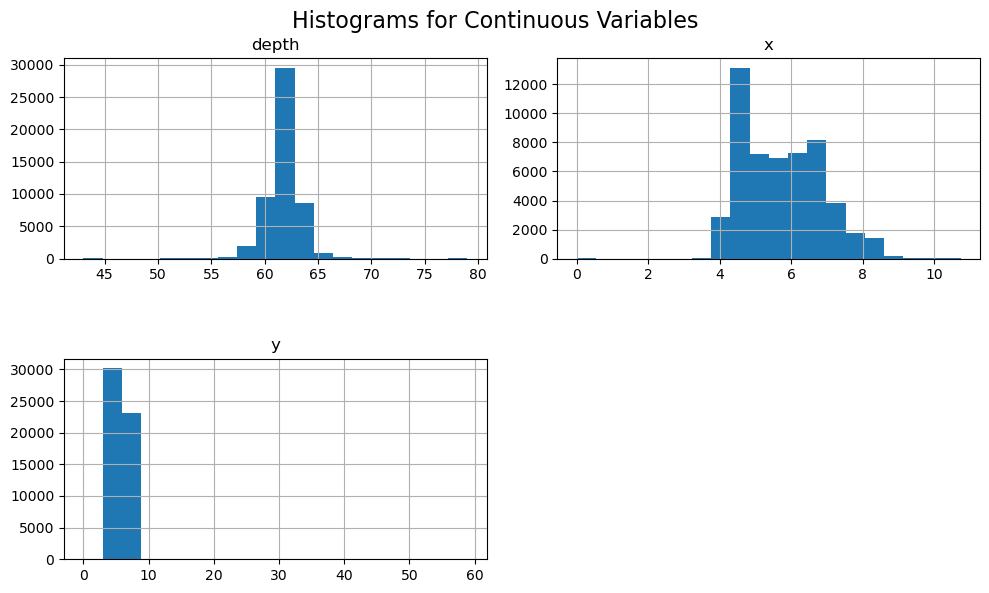

In [30]:
# Knowing the distributions of features with missing values
plot_distributions(data, ['depth', 'x', 'y'])

I decided to use median imputation for x & y features and mean imputation for depth as only depth follows a normal distribution, the mean imputation is more robust to outliers and does not disort the distribution. 

In [31]:
# Replace null values for depth variable
mean_imputing(data, 'depth')

for var in ['x', 'y']:
    meadian_imputing(data, var)

# Testing the changes
print(tabulate(dqr(data), headers='keys', tablefmt='pretty', showindex=False))

+-----------+---------+----------------+----------------+---------------+-------------+------------+
|   Names   |  Type   | Missing_values | Present_values | Unique_values |  Min_value  | Max_value  |
+-----------+---------+----------------+----------------+---------------+-------------+------------+
|   carat   | float64 |       0        |     53930      |      273      |     0.2     |    5.01    |
|    cut    | object  |       0        |     53930      |       5       |    Fair     |  VeryGood  |
|   color   | object  |       0        |     53930      |       7       |      D      |     J      |
|  clarity  | object  |       0        |     53930      |       8       |     I1      |    VVS2    |
|   depth   | float64 |       0        |     53930      |      185      |    43.0     |    79.0    |
|   table   | float64 |       0        |     53930      |      127      |    43.0     |    95.0    |
|   price   |  int64  |       0        |     53930      |     11602     |     326     |   1

Now that I don't have missing values I will proceed to encode the categorical features. As the categorical features all have ordinality (for instance Premium is better than Ideal and Ideal is better than Good), I can use ordinal encoder to convert the classes to a number to later use those features in a regression problem. 

The ordinal mapping is presented below is given by the following dictonaries:

In [32]:
# Creating the ordinal encoder maps
cut_mapping = {
    'Fair': 1,
    'Good': 2,
    'VeryGood': 3,
    'Premium': 4,
    'Ideal': 5
}

color_mapping = {
    'J': 1,
    'I': 2,
    'H': 3,
    'G': 4,
    'F': 5,
    'E': 6,
    'D': 7
}

clarity_mapping = {
    'I1': 1,
    'SI2': 2,
    'SI1': 3,
    'VS2': 4,
    'VS1': 5,
    'VVS2': 6,
    'VVS1': 7,
    'IF': 8
}

mappings = {
    'cut': cut_mapping,
    'color': color_mapping,
    'clarity': clarity_mapping
}

for var, mapping in mappings.items():
    ordinal_encoding(data, var, mapping)


# Checking the unique values in the encoded variables
for i in ['cut', 'color', 'clarity']:
    print("Unique values for ", i, "var:")
    print(data[i].unique())

Unique values for  cut var:
[5 4 2 3 1]
Unique values for  color var:
[6 2 1 3 5 4 7]
Unique values for  clarity var:
[2 3 5 4 6 7 1 8]


Now that I have encoded the categorical values and replaced missing values I will analyze the linearity between the features in respect of the target variable. 

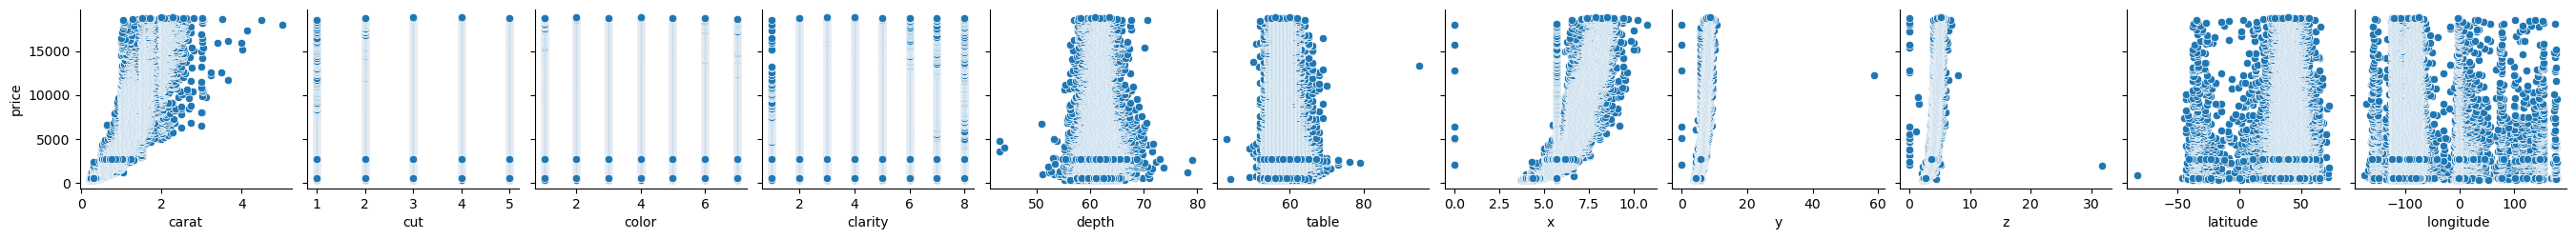

In [34]:
plot_linearity(data, data.drop('price', axis=1).columns, 'price')

As we can see in the last plot, there seem to be some outliers that are making hard to interpret the linearity, although there are some others in which we clearly see that there is not probably a correlation between the price an those features such as latitude and longitude. That being said I will take rid of the outliers using the standard deviatin from each feature. 

In [36]:
# Recuersevely start deleting outliers
data_without_outliers = data.copy()

for column in ['depth', 'table', 'x', 'y', 'z']:
    data_without_outliers = remove_outliers_sd(data_without_outliers, column)
    print("column: ", column, " ", data_without_outliers.shape[0])

column:  depth   53205
column:  table   52718
column:  x   52678
column:  y   52677
column:  z   52656


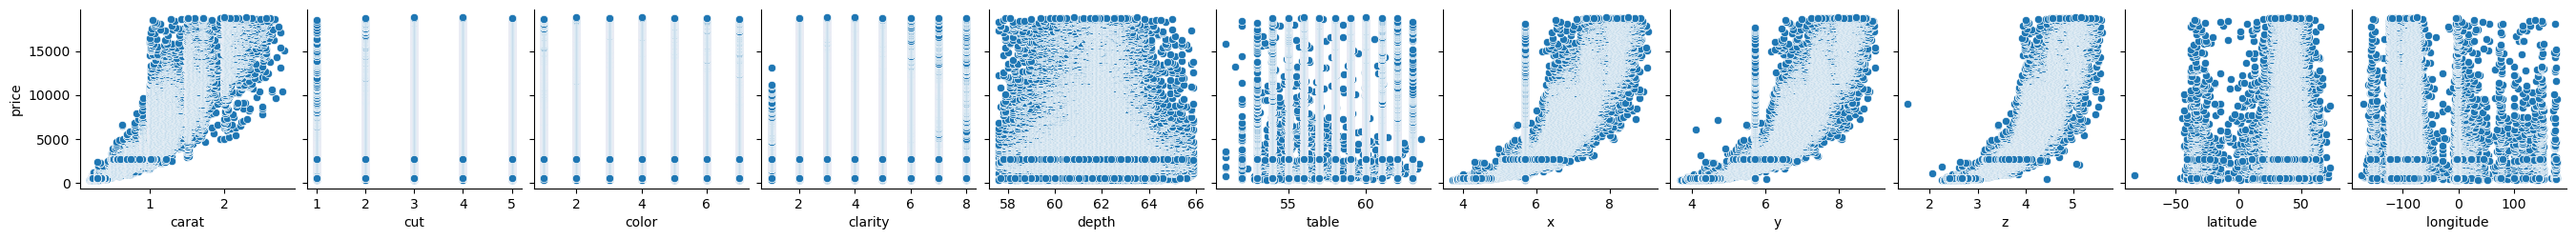

In [37]:
plot_linearity(data_without_outliers, data_without_outliers.drop('price', axis=1).columns, 'price')

After removing outliers we can now see some patterns in the some features, we -kind of- see the correlation between the size (x, y & z vectors) and the carat of the diamond to the price of the diamond, it seems that as the diamond is bigger and the carat increases the price do as well. However, it is intersting that is not exactly a linear relationship, which might indicate that I am not facing a linear problem so models such as SVR or ensamblers might be better for the model.